In [7]:
import argparse
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from importlib import reload

from analysis import forgetting

from wildtime import baseline_trainer, dataloader
from wildtime.configs.eval_fix import (
    configs_mimic_mortality, configs_mimic_readmission, 
    configs_fmow, configs_arxiv, configs_huffpost, configs_yearbook
)

In [2]:
reload(forgetting)

<module 'analysis.forgetting' from '/home/jaredfer/Projects/distshift/Wild-Time/analysis/forgetting.py'>

In [2]:
DATA_DIR="/data/tir/projects/tir6/strubell/jaredfer/projects/wild-time/results"

EXP_PATHS =  {
    ('fmow', 'cs'): "0504_fmow_swa_coldstart_csaw",
    ('fmow', 'ws'): "0504_fmow_swa_csaw_lambda0.75", 
    ('huffpost', 'cs'): "0504_huffpost_swa_coldstart_csaw",
    ('huffpost', 'ws'): "0504_huffpost_swa_warmstart_csaw_2",
    ('arxiv', 'cs'): "0509_arxiv_swa_coldstart_csaw_seed_1" ,
    ('arxiv', 'ws'): "0509_arxiv_swa_warmstart_csaw_seed_1",
    ('yearbook', 'cs'): "0504_yearbook_swa_coldstart_csaw",
    ('yearbook', 'ws'): "0504_yearbook_swa_csaw_lambda0.75",
}

OPTIMAL_DECAY = {
    ('fmow', 'cs'): 0.90,
    ('fmow', 'ws'): 0.75, 
    ('huffpost', 'cs'): 0.85,
    ('huffpost', 'ws'): 0.45,
    ('arxiv', 'cs'): 0.75,
    ('arxiv', 'ws'): 0.50,
    ('yearbook', 'cs'): 0.90,
    ('yearbook', 'ws'): 0.75,
}

In [70]:
EXP_PARAMS = {
    'dataset': "fmow",
    'method': 'swa',
    'eval_batch_size': 2048,
    'swa_ewa_lambda': 0.90,
    'exp_path': 'seed_2',

    'device': 0,
    'random_seed': 1,
    'num_workers': 0,

    'eval_fix': True,
    'eval_warmstart_finetune': False,
    'eval_features': False,
    'linear_probe': False,
    'online': False,
    'offline_steps': 1000,
    'online_steps': 1000,

    'eval_all_timestamps': False,

    'load_model': False,
    'torch_compile': False,
    'sam': False,
    'swa_ewa': True,
    'swa_steps': None,
    'swa_load_from_checkpoint': False,

    'data_dir': '/data/tir/projects/tir6/strubell/data/wilds/data',
    'log_dir': '/data/tir/projects/tir6/strubell/jaredfer/projects/wild-time/results',
    'results_dir': '/data/tir/projects/tir6/strubell/jaredfer/projects/wild-time/results/icml/fmow/ewc',
    'checkpoint_path': ''

    # 'checkpoint_path': '/data/tir/projects/tir6/strubell/jaredfer/projects/wild-time/results/0509_arxiv_swa_warmstart_csaw_seed_1/time_2016'
}

if EXP_PARAMS['dataset'] == 'fmow':
    config =  {**configs_fmow.configs_fmow_erm, **EXP_PARAMS}
    eval_checkpoints = [f"time_{i}.pth" for i in range(11)]
if EXP_PARAMS['dataset'] == 'huffpost':
    config =  {**configs_huffpost.configs_huffpost_erm, **EXP_PARAMS}
    eval_checkpoints = [f"time_{i}.pth" for i in range(2012, 2016)]
if EXP_PARAMS['dataset'] == 'arxiv':
    eval_checkpoints = [f"time_{i}.pth" for i in range(2007, 2016)]
    config = {**configs_arxiv.configs_arxiv_erm, **EXP_PARAMS}
if EXP_PARAMS['dataset'] == 'yearbook':
    eval_checkpoints = [f"time_{i}.pth" for i in range(1930, 1970)]
    config = {**configs_yearbook.configs_yearbook_erm, **EXP_PARAMS}
if EXP_PARAMS['dataset'] == 'mimic':
    config = {**configs_mimic_mortality.configs_mimic_mortality_erm, **EXP_PARAMS}

experimental_config = argparse.Namespace(**config)

In [8]:
trainer = baseline_trainer.init(experimental_config)

In [6]:
eval_splits = [t for t in trainer.eval_dataset.ENV if t > trainer.split_time]

for decay in [0.85, 1]: #  np.arange(0.5, 1, 0.1):
   accs = []
   trainer.create_csaw_from_ckpts(0, lambda_val=decay, wise_ft=False)

   for t in eval_splits:
      accs.append(trainer.run_eval_timestamp(t, 2)[0])
      print(f"Time {t}, acc {accs[-1]}")


   print(f"Decay {decay}: {np.mean(accs)}")

100%|██████████| 2/2 [00:31<00:00, 15.51s/it]


Time 11, acc 0.5851948051948052


100%|██████████| 4/4 [00:45<00:00, 11.49s/it]


Time 12, acc 0.5962532299741602


100%|██████████| 5/5 [01:15<00:00, 15.09s/it]


Time 13, acc 0.5384381646915831


100%|██████████| 8/8 [01:59<00:00, 15.00s/it]


Time 14, acc 0.48305031643586693


100%|██████████| 4/4 [00:48<00:00, 12.09s/it]


Time 15, acc 0.42250772483330623
Decay 0.85: 0.5250888482259443


100%|██████████| 2/2 [00:29<00:00, 14.76s/it]


Time 11, acc 0.5836363636363636


100%|██████████| 4/4 [00:47<00:00, 11.96s/it]


Time 12, acc 0.5928617571059431


100%|██████████| 5/5 [01:16<00:00, 15.30s/it]


Time 13, acc 0.5362098652891725


100%|██████████| 8/8 [02:02<00:00, 15.30s/it]


Time 14, acc 0.4750924243373645


100%|██████████| 4/4 [00:48<00:00, 12.11s/it]

Time 15, acc 0.42510977394698324
Decay 1: 0.5225820368631655


100%|██████████| 2/2 [00:30<00:00, 15.28s/it]
Time 11, acc 0.632987012987013
100%|██████████| 4/4 [00:47<00:00, 11.86s/it]
Time 12, acc 0.6359819121447028
100%|██████████| 5/5 [01:16<00:00, 15.34s/it]
Time 13, acc 0.5607211587156893
100%|██████████| 8/8 [02:01<00:00, 15.21s/it]
Time 14, acc 0.4977128892787769
100%|██████████| 4/4 [00:46<00:00, 11.67s/it]
Time 15, acc 0.4348674581232721
Decay 0.9: 0.5524540862498908


100%|██████████| 2/2 [00:27<00:00, 13.85s/it]
Time 11, acc 0.6311688311688312
100%|██████████| 4/4 [00:47<00:00, 11.90s/it]
Time 12, acc 0.6314599483204134
100%|██████████| 5/5 [01:15<00:00, 15.07s/it]
Time 13, acc 0.5526182517978325
100%|██████████| 8/8 [02:04<00:00, 15.53s/it]
Time 14, acc 0.4930133467009211
100%|██████████| 4/4 [00:51<00:00, 12.98s/it]
Time 15, acc 0.4364937388193202
Decay 1: 0.5489508233614637

In [ ]:
import forgetting_main as fm
reload(fm)

trainer.swa_ewa_lambda = 0.50

eval_ckpts = [f"time_{i}.pth" for i in range(2012, 2016)]
data_dir = os.path.join(config['results_dir'], config['exp_path'])
_, pred_logits, labels = fm.get_predictions(trainer,  [f"time_{i}.pth" for i in range(2012, 2016)], data_dir)


In [23]:
trainer.split_time

2015

In [3]:
RESULTS_DIR="/data/tir/projects/tir6/strubell/jaredfer/projects/wild-time/results/icml"

In [37]:
dataset = "arxiv"
init = "ws"

for dataset in ['huffpost', 'fmow', 'arxiv']:
    for seed in range(3):
        for method in ['ewc', 'ft']:
            EXP=f"{dataset}/{method}/seed_{seed}"
            data_fpath = os.path.join(RESULTS_DIR, EXP, f'preds_meta_swa_opt.pkl')
            data_swa = forgetting.load_predictions_and_metadata(data_fpath)


            data_fpath = os.path.join(RESULTS_DIR, EXP, 'preds_meta_swa_1.0.pkl')
            data = forgetting.load_predictions_and_metadata(data_fpath)
            
            data = add_confidence_stability(data)
            data_swa = add_confidence_stability(data_swa)

            corr = [_[-1].mean() for _ in data['corr']]
            corr_swa = [_[-1].mean() for _ in data_swa['corr']]

            print(EXP)
            print(corr, np.mean(corr))
            print(corr_swa, np.mean(corr_swa))
            print("Avg Diff: ", np.mean(corr_swa)- np.mean(corr))
            print("Worst Diff: ", np.min(corr_swa)- np.min(corr))


            print()

huffpost/ewc/seed_0
[0.7306543810255097, 0.6881402230821762, 0.7197943444730077] 0.7128629828602312
[0.7319341353126866, 0.704302299112224, 0.7308483290488432] 0.7223615878245845
Avg Diff:  0.009498604964353285
Worst Diff:  0.016162076030047823

huffpost/ft/seed_0
[0.7283508233085915, 0.6944001821078989, 0.7233933161953727] 0.7153814405372877
[0.7307396979779882, 0.7024812201229228, 0.7290488431876607] 0.7207565870961906
Avg Diff:  0.005375146558902921
Worst Diff:  0.008081038015023911

huffpost/ewc/seed_1
[0.7333845235048204, 0.6934896426132483, 0.7262210796915167] 0.7176984152698619
[0.736114665984131, 0.7017983155019349, 0.7398457583547557] 0.7259195799469406
Avg Diff:  0.008221164677078674
Worst Diff:  0.008308672888686641

huffpost/ft/seed_1
[0.7239143417797116, 0.6732301388572729, 0.6917737789203084] 0.6963060865190975
[0.7286067741660268, 0.6776690188936945, 0.6961439588688946] 0.7008065839762053
Avg Diff:  0.004500497457107788
Worst Diff:  0.004438880036421566

huffpost/ewc/see

In [22]:
from collections import defaultdict
def add_confidence_stability(data):
    data['corr'] = []
    data['confidence_pred'] = []
    data['stability_pred'] = []
    data['confidence_pred_mean'] = []
    data['confidence_pred_delta'] = []

    data['confidence_gt'] = []
    data['stability_gt'] = []
    data['confidence_gt_mean'] = []
    data['confidence_gt_delta'] = []

    for i in range(len(data['labels'])):
        pred_probs = data['pred_probs'][i]
        pred_labels = data['pred_labels'][i]
        labels = data['labels'][i]



        data['corr'].append(labels == pred_labels)
        data['confidence_pred'].append(pred_probs.max(axis=2))
        data['stability_pred'].append(data['confidence_pred'][-1].std(axis=0))
        data['confidence_pred_mean'].append(data['confidence_pred'][-1].mean(axis=0))
        data['confidence_pred_delta'].append(data['confidence_pred'][-1][-1] - data['confidence_pred'][-1][0])

        data['confidence_gt'].append(pred_probs[np.arange(labels.shape[0])[:, None], np.arange(labels.shape[1]), labels])
        data['stability_gt'].append(data['confidence_gt'][-1].std(axis=0))
        data['confidence_gt_mean'].append(data['confidence_gt'][-1].mean(axis=0))
        data['confidence_gt_delta'].append(data['confidence_gt'][-1][-1] - data['confidence_gt'][-1][0])
    return data


# confidence = pred_probs[:, labels]
# confidence.shape

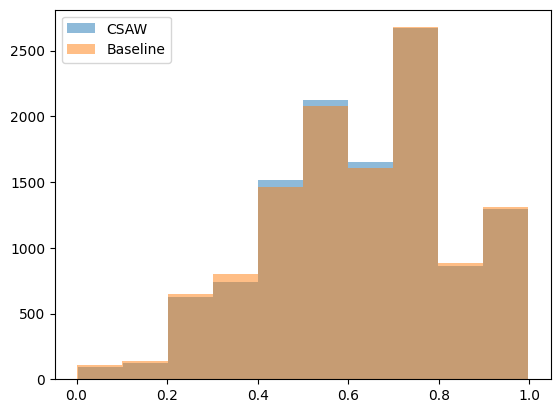

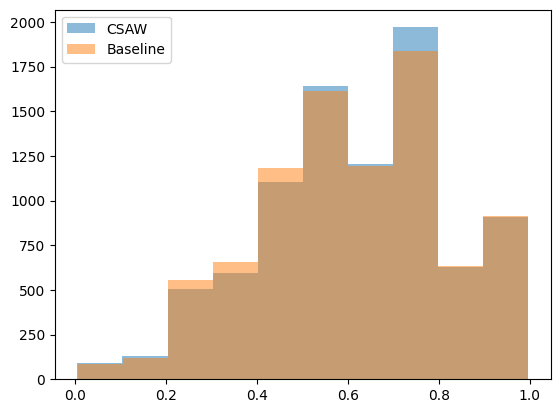

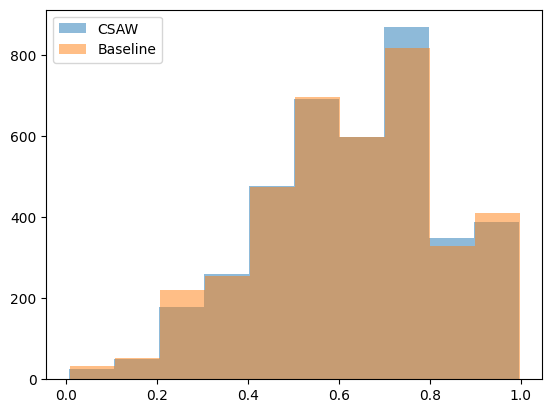

In [27]:
data = add_confidence_stability(data)
data_swa = add_confidence_stability(data_swa)

for i in range(3):
    plt.hist(data_swa['confidence_gt_mean'][i], alpha=0.50, label="CSAW")
    plt.hist(data['confidence_gt_mean'][i], alpha=0.50, label="Baseline")
    plt.legend()
    plt.show()

# plt.hist(confidence_gt_mean)

In [254]:
transferred = data['transferred'][0]
hard = data['hard'][0]

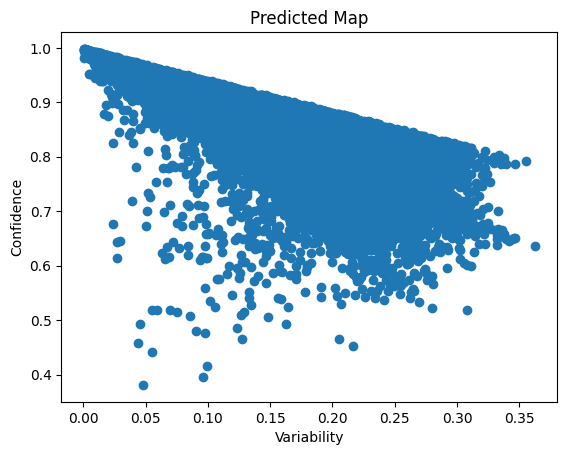

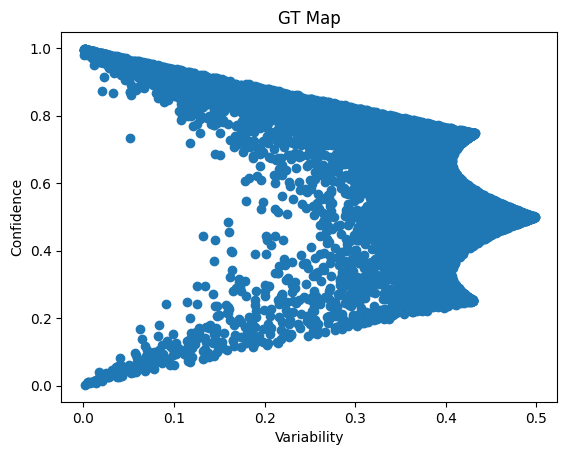

In [33]:
import matplotlib.pyplot as plt
plt.scatter(data['stability_pred'][0], data['confidence_pred_mean'][0])
plt.title('Predicted Map')
plt.xlabel('Variability')
plt.ylabel('Confidence')
plt.show()

plt.scatter(data['stability_gt'][0], data['confidence_gt_mean'][0])
plt.title('GT Map')
plt.xlabel('Variability')
plt.ylabel('Confidence')
plt.show()



In [365]:
corr = forgetting.get_correctness(data)
corr_swa = forgetting.get_correctness(data_swa)
DIFF_ALL=False
ft_events = forgetting.evaluate_method(corr, corr, diff_all=DIFF_ALL)
csaw_events = forgetting.evaluate_method(corr, corr_swa, diff_all=DIFF_ALL)

for t in range(len(ft_events[0])):
    print(f"Eval on {t}")
    transferred =np.array(csaw_events[0][t]) - np.array(ft_events[0][t]) 
    learned = np.array(csaw_events[2][t]) - np.array(ft_events[2][t])
    print("Transferred", transferred, transferred.mean())
    print("Learned",  learned, learned.mean())
    # print("Forgotten", np.array(csaw_events[3][t]) - np.array(ft_events[3][t]), '\n')


Eval on 0
Transferred [ 17  23  10 -28  28  17  36  18   5  10] 13.6
Learned [ 17   5  -4  43   7  12 -19 -20   2   1] 4.4
Eval on 1
Transferred [ -7   5  -1   6  -3   0  12 -52   9  26] -0.5
Learned [22 46 29 -1 44 30 -9 57 -3  9] 22.4
Eval on 2
Transferred [-10  13   6 -21  -6  57 -27  24 -30  22] 2.8
Learned [ 15  38  39  15  71  -3  53 -15  32  22] 26.7
Eval on 3
Transferred [-10  47  77   7  36  46   7  52  35  53] 35.0
Learned [ 37  35 -23  27  94   4  14 -82  10  -1] 11.5
Eval on 4
Transferred [-23  -7  25  -2  -4   1 -27  14  23   5] 0.5
Learned [ 30  17  10   2  40  37  39 -40 -11  -7] 11.7


In [ ]:
# FT WS
[_[-1].mean() for _ in corr], [_[-1].mean() for _ in corr_swa]

In [368]:
[_[-1].mean() for _ in corr], [_[-1].mean() for _ in corr_swa]

([0.5815584415584416,
  0.5812338501291989,
  0.5318545528208245,
  0.4733379284416317,
  0.40022767929744674],
 [0.5844155844155844,
  0.5868863049095607,
  0.5363111516256457,
  0.4765962779622783,
  0.3999024231582371])

In [ ]:
[[_, corr[-1][_].mean()] for _ in range(11)]

0.7128629828602312
0.7228740468904705


In [48]:
print(([_[-1].mean() for _ in corr]))
print(([_[-1].mean() for _ in corr_swa]))




[0.581038961038961, 0.5915697674418605, 0.5317532664843513, 0.47383921298326964, 0.42071881606765327]
[0.5844155844155844, 0.5868863049095607, 0.5363111516256457, 0.4765962779622783, 0.3999024231582371]


In [ ]:
sankey_nodes = construct_example_flow_graph(data_swa['transferred'][-1][6:], data_swa['hard'][-1][6:], data_swa['learned'][-1][6:], data_swa['forgotten'][-1][6:])
source, target,value, node_labels, color, node_heights = convert_flow_graph_to_plotly(sankey_nodes)
plot_sankey(source, target,value, node_labels, color, node_heights / max(node_heights), title=f"CSAW: {data['model']}").show()

In [ ]:
sankey_nodes = construct_example_flow_graph(data['transferred'][-1][6:], data['hard'][-1][6:], data['learned'][-1][6:], data['forgotten'][-1][6:])
source, target,value, node_labels, color, node_heights = convert_flow_graph_to_plotly(sankey_nodes)
plot_sankey(source, target,value, node_labels, color, node_heights / max(node_heights), title=f"FT: {data['model']}").show()

In [ ]:
sankey_nodes = construct_example_flow_graph(data['transferred'][-1][8:], data['hard'][-1][8:], data['learned'][-1][8:], data['forgotten'][-1][8:])
source, target,value, node_labels, color, node_heights = convert_flow_graph_to_plotly(sankey_nodes)
plot_sankey(source, target,value, node_labels, color, node_heights / max(node_heights), title=f"Splits 11: {data['model']}").show()

In [ ]:

transferred, hard, learned, forgotten = find_learning_and_forgetting_events(np.hstack(labels), pred_labels=np.hstack(pred_labels))

sankey_nodes = construct_example_flow_graph(transferred, hard, learned, forgotten)

# source, target,value, labels, color, node_heights
source, target,value, node_labels, color, node_heights = convert_flow_graph_to_plotly(
    sankey_nodes, learned, forgotten
)
plot_sankey([], color, source, target, value, title=f"All Eval Splits: {MODEL}").show()

In [ ]:
MODEL = "Warmstart FT"
for split, label, pred_label in zip(eval_splits, labels, pred_labels):
    transferred, hard, learned, forgotten = find_learning_and_forgetting_events(label, pred_labels=pred_label)

    sankey_nodes = construct_example_flow_graph(transferred, hard, learned, forgotten)
    source, target,value, node_labels, color, node_heights = convert_flow_graph_to_plotly(sankey_nodes)
    plot_sankey([], color, source, target, value, title=f"at time {split}: {MODEL}").show()